## Example notebook

This notebook shows how to train (and save) a single RNN (on the prediction and/or matching task). Next, it shows how to load a previously trained notebook for visual inspection. Finally, it will show the functions that train many RNNs automatically. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from tqdm import tqdm
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))
import torch

import bptt_rnn_mtl as bpm
import plot_routines as pr  # plotting functions & directly related
import plot_routines_mtl as prm
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

prm.set_fontsize(12)
plt.rcParams['axes.linewidth'] = 1.25  # defaul t0.8

cpu


## 1) Training an RNN

First, we generate data:

In [2]:
# Data parameters dictionary
d_dict = {'n_total': 1000,  # total number of trials
         'ratio_train': 0.8,  # fraction of training set (remainder will be test set)
         'ratio_exp': 0.75,  # fraction of expected trials
         'noise_scale': 0.15,  # std of white noise added to input data
         't_delay': 2,  # duration of delay periods in number of time steps 
         't_stim': 2}  # duration of stimulus periods in number of time steps 

## Set training parameters:
t_dict = {}
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
t_dict['learning_rate'] = 0.002  # algorithm lr
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 30  # training epochs (each epoch uses n_total trials)
t_dict['l1_param'] = 1e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 

In [3]:
tmp0, tmp1 = bpm.generate_synt_data_general(n_total=d_dict['n_total'], t_delay=d_dict['t_delay'], t_stim=d_dict['t_stim'], 
                                        ratio_train=d_dict['ratio_train'], ratio_exp=d_dict['ratio_exp'],
                                        noise_scale=d_dict['noise_scale'], 
                                        late_s2=False,  # if True; later S2 delivery
                                        early_match=False,  # if True; prompt match early
                                        nature_stim='onehot', # onehot for 2 samples, periodic for 4
                                        task='dmc')  # specify match task type (dmc, dms, dmrc, dmrs)
                    
## Extract input (x), output-to-be-predicted (y), split by train and test, and their labels
x_train, y_train, x_test, y_test = tmp0  # dtype is torch arrays
labels_train, labels_test = tmp1

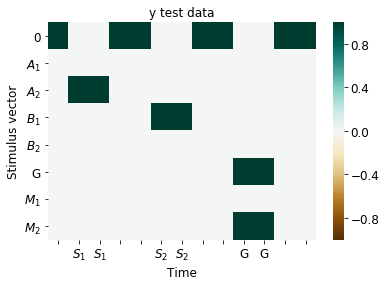

In [4]:
## Plot example trials:

ax_true = plt.subplot(111)
k = np.where(labels_test == '2x')[0]  # trial index (eg, select all trials labelled as .. )
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), # go to numpy data types
                    ax=ax_true,
                     vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

Next, we train a RNN:

In [5]:
## Set up things for training:
## RNN is a class that holds the network:
rnn = bpm.RNN_MTL(task='pred_dmc',  # which task(s) to train on
                  nature_stim='onehot',  # data type (make sure it's the same as data generation)
                  n_nodes=t_dict['n_nodes'])  # number of neurons
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorch
rnn.set_info(param_dict={**d_dict, **t_dict})  # store these parameter values

In [6]:
## This command trains the network:
rnn = bpm.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                        x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test,  # give it the data
                        verbose=0, late_s2=False, use_gpu=False, 
                        simulated_annealing=False,  # simulated annealing means changing the probability of expected trials
                        ratio_exp_array=None,  # if using simulated annealing, this array should contain probability array over epochs 
                        save_state=True)  # save parameter state after each epoch?

Epoch 29/30. Train loss: 0.975144: 100%|██████████| 30/30 [04:41<00:00,  9.37s/it]     


Assess outcome of training (compare predicted trials vs actual trials):

Trial type: ['11']


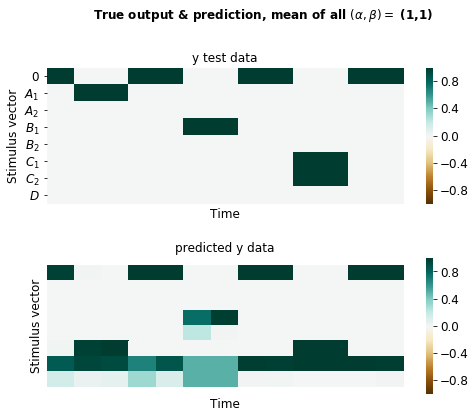

In [7]:
## Plot example test sample & prediction

k = np.where(labels_test == '11')[0]
print(f'Trial type: {np.unique(labels_test[k])}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8, 6)
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
                      xticklabels=[], vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[], vmin=-1, c_map='BrBG')  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);


## 2) Load previously trained RNNs

i_rnn: 0,  rnn-mnm_2021-05-21-2249d.data
Trial type: ['11']
pred: 0.5733127474784852
dmc: 0.00874920692294836


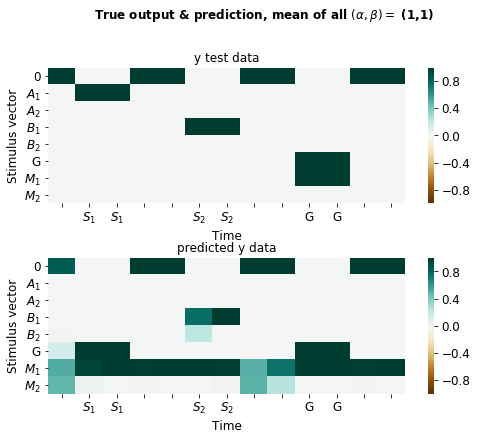

In [8]:
i_rnn = 0
folder_rnn = 'models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/'
# list_rnns = [x for x in os.listdir(folder_rnn) if ru.timestamp_min_date(rnn_name=x)]  # use if you want to select particular dates of training
list_rnns = os.listdir(folder_rnn)
filename = list_rnns[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_rnn, filename))
print(f'i_rnn: {i_rnn}, ', filename)


## Plot example test sample & prediction
k = np.where(labels_test == '11')[0]
print(f'Trial type: {np.unique(labels_test[k])}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]

if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true, vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); 

ax_pred = plt.subplot(212)
prm.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred, vmin=-1, c_map='BrBG')  # average if multiple samples
ax_pred.set_title("predicted y data"); 

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);

for key in ['pred', 'dmc']:
    if key in rnn.test_loss_split.keys():
        print(f'{key}:', np.mean(rnn.test_loss_split[key][-5:]))

Text(0, 0.5, 'Test loss')

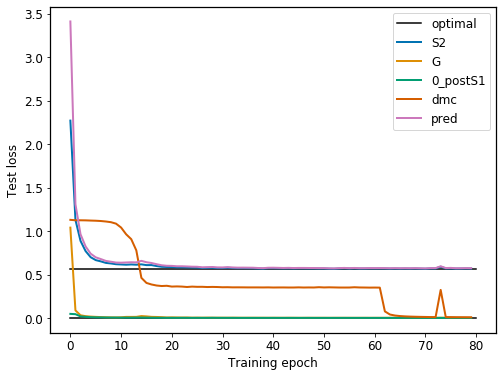

In [9]:
## Inspect loss trajectories for this particular RNN:
nature_stim = 'onehot'

## Optimal loss can be analytically derived for all types of task
if nature_stim == 'onehot':
    optimal_pred_loss = -0.25 * np.log(0.25) - 0.75 * np.log(0.75)
elif nature_stim == 'periodic':
    optimal_pred_loss = 5 / 9
optimal_match_loss = 0

## Plot:
ax_loss = plt.subplot(111)
ax_loss.plot([0, 80], [0, 0],c='k')
ax_loss.plot([0, 80], [optimal_pred_loss, optimal_pred_loss], c='k', label='optimal')
for kk in ['S2', 'G', '0_postS1', 'dmc', 'pred']:
    ax_loss.plot(rnn.test_loss_split[kk], label=kk, linewidth=2)
ax_loss.legend()
ax_loss.set_xlabel('Training epoch')
ax_loss.set_ylabel('Test loss')

## 3) Training RNNs in bulk

To train many RNNs per initial conditions (who differ in random weight initialisation and added noise), and across conditions, use the following functions. 
**NB**: I use these in terminal in the background, for better thread-management & avoiding jupyter time-out issues.

`import bptt_rnn_mtl as bpm`

`bpm.summary_many()`


The `bpm.summary_many()` function takes all key arguments (task type, network size etc) as lists, so you can specify multiple conditions to be trained. A grid of all possible combinations will be trained. Per condition, `n_sim` networks will be trained. Each RNN is saved directly after it's trained, by automatically creating folders for each combination of parameters. To speed up training, CPU multi-threading is used for lazy parallelization of training multiple RNNs (see `bpm.init_train_save_rnn()`, with default value of `n_threads=10` threads in parallel). 